In [1]:
import numpy as np
from scipy import fftpack
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import ghibtools as gh
from scipy import signal

In [2]:
data = np.random.randn(10,20)

In [3]:
data.shape

(10, 20)

In [4]:
data[ :, np.newaxis].shape

(10, 1, 20)

In [ ]:
range_freqs = np.linspace(10,40,0.5)
n_cycles = np.linspace(10,20,step) 

In [258]:
def homemade_tf(sig, f_start, f_stop, n_steps, cycle_start, cycle_stop, srate, wavelet_duration = 2, squaring=True):
    
    a = 1 # amplitude of the cmw
    m = 0 # max time point of the cmw
    time_cmw = np.arange(-wavelet_duration,wavelet_duration,1/srate) # time vector of the cmw
    range_freqs = np.linspace(f_start,f_stop,n_steps) 
    n_cycles = np.linspace(cycle_start,cycle_stop,n_steps) # n cycles depends on fi

    time_sig = np.arange(0, sig.size / srate , 1 / srate)

    shape = (range_freqs.size , time_sig.size)
    data = np.zeros(shape)
    dims = ['freqs','time']
    coords = {'freqs':range_freqs, 'time':time_sig}
    tf = xr.DataArray(data = data, dims = dims, coords = coords)
    
    for i, fi in enumerate(range_freqs):
        
        ni = n_cycles[i]
        cmw_f = gh.complex_mw(a=a, time=time_cmw, n=ni, freq=fi, m = m) # make the complex mw
        complex_conv = signal.convolve(sig, cmw_f, mode = 'same')
        if squaring:
            module = np.abs(complex_conv) ** 2
        else:
            module = np.abs(complex_conv) # abs method without squaring (more "real")

        tf.loc[fi,:] = module

    return tf

In [5]:
def generate_wavelet_fourier(len_wavelet, f_start, f_stop, delta_freq, sampling_rate, f0, normalisation):
    """
    Compute the wavelet coefficients at all scales and makes its Fourier transform.
    When different signal scalograms are computed with the exact same coefficients, 
        this function can be executed only once and its result passed directly to compute_morlet_scalogram
        
    Output:
        wf : Fourier transform of the wavelet coefficients (after weighting), Fourier frequencies are the first 
    """
    # compute final map scales
    scales = f0/np.arange(f_start,f_stop,delta_freq)*sampling_rate
    # compute wavelet coeffs at all scales
    xi=np.arange(-len_wavelet/2.,len_wavelet/2.)
    xsd = xi[:,np.newaxis] / scales
    wavelet_coefs=np.exp(complex(1j)*2.*np.pi*f0*xsd)*np.exp(-np.power(xsd,2)/2.)

    weighting_function = lambda x: x**(-(1.0+normalisation))
    wavelet_coefs = wavelet_coefs*weighting_function(scales[np.newaxis,:])

    # Transform the wavelet into the Fourier domain
    #~ wf=fft(wavelet_coefs.conj(),axis=0) <- FALSE
    wf=fftpack.fft(wavelet_coefs,axis=0)
    wf=wf.conj() # at this point there was a mistake in the original script
    
    return wf


def convolve_scalogram(sig, wf):
    """
    Convolve with fft the signal (in time domain) with the wavelet
    already computed in freq domain.
    
    Parameters
    ----------
    sig: numpy.ndarray (1D, float)
        The signal
    wf: numpy.array (2D, complex)
        The wavelet coefficient in fourrier domain.
    """
    n = wf.shape[0]
    assert sig.shape[0]<=n, 'the sig.size is longer than wf.shape[0] {} {}'.format(sig.shape[0], wf.shape[0])
    sigf=fftpack.fft(sig,n)
    wt_tmp=fftpack.ifft(sigf[:,np.newaxis]*wf,axis=0)
    wt = fftpack.fftshift(wt_tmp,axes=[0])
    return wt

In [6]:
def load_data(patient = 'P1'):
    input_file = f'../dataarray/da_staged_{patient}.nc'
    da = xr.load_dataarray(input_file)
    return da.sel(stage = 'N2').dropna('time')

In [7]:
da = load_data()

In [8]:
da

<xarray.DataArray (chan: 11, time: 1743360)>
array([[  14.1151877 ,   13.70419411,   13.799742  , ...,   34.27525882,
          38.88457115,   40.13338932],
       [  40.28148136,   37.67380939,   35.99235406, ...,   72.69009321,
          73.38810715,   74.18784169],
       [ -76.98529802,  -77.58474729,  -78.81230826, ...,  -84.08693574,
         -83.29408914,  -82.96278305],
       ...,
       [  -2.00504407,   -2.05361794,   -2.00091981, ...,   -0.89872598,
          -0.93720193,   -0.94219937],
       [  88.76083622,   81.48866811,   83.46173564, ...,   37.24223891,
          38.35913704,   40.24587128],
       [  35.73141468,   39.09667053,   43.53701647, ..., -178.51958078,
        -182.94747319, -185.30115211]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 6.81e+03 6.81e+03 6.81e+03
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'DEBIT' 'THERM' 'ECG'
    stage    <U2 'N2'

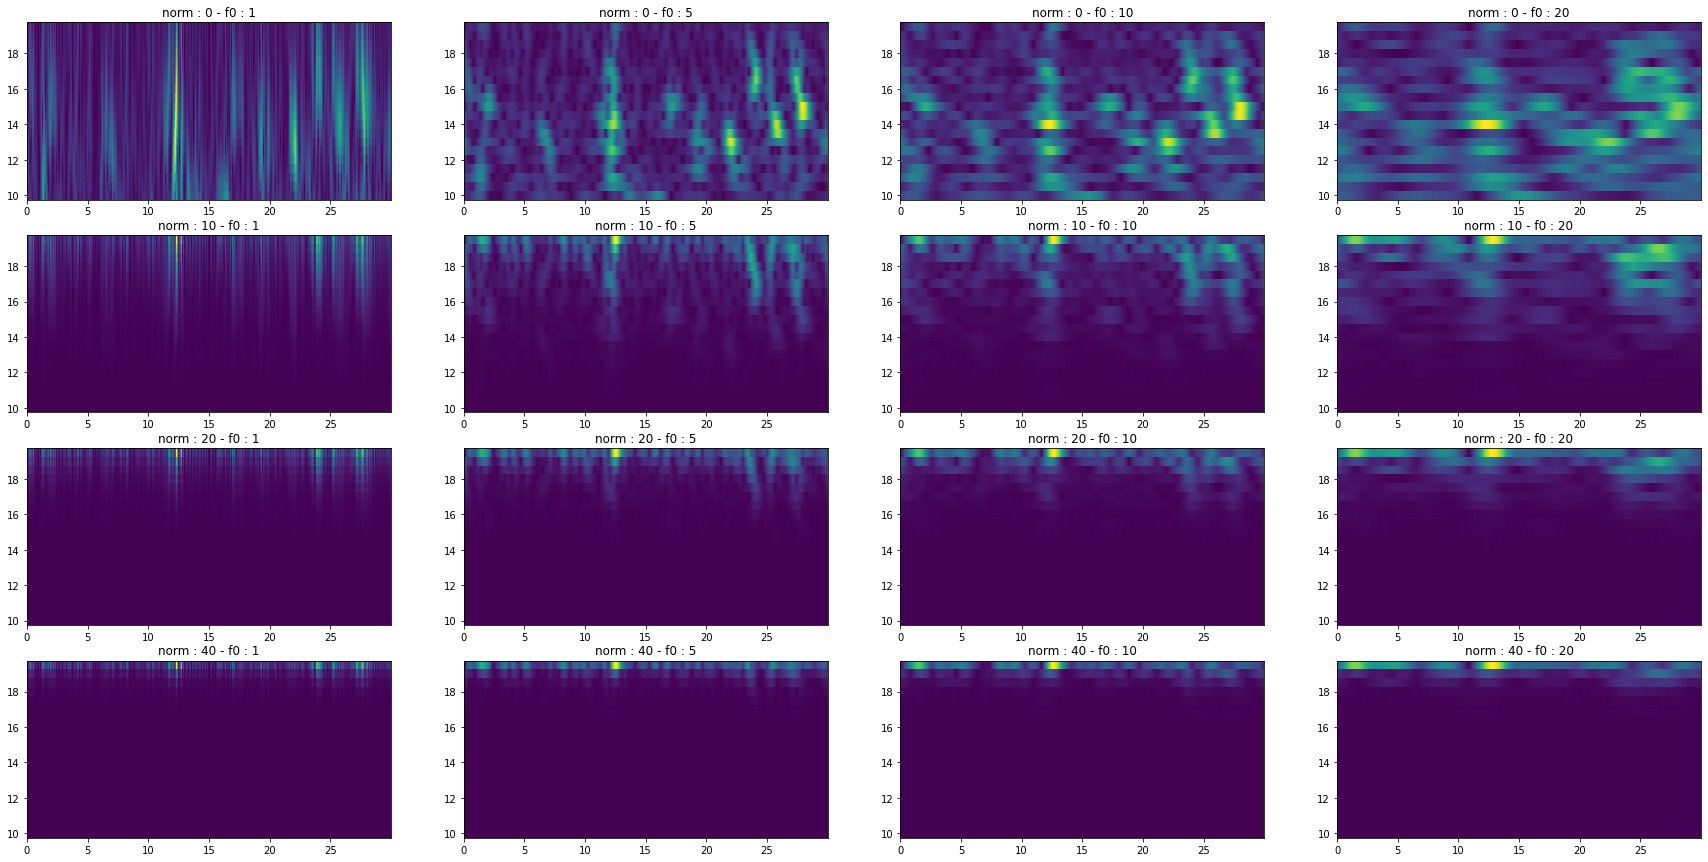

In [9]:
srate = 256

start = 10
stop = 40

sig = da[0,start*srate:stop*srate].values
time = gh.time_vector(sig, srate)

step = 0.5

fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (30,15))

for row, normalisation in enumerate([0 , 10 , 20, 40]):
    for col, f0 in enumerate([1 , 5 , 10 , 20]):
        
        ax = axs[row, col]
        wf = generate_wavelet_fourier(len_wavelet=sig.size, f_start=10, f_stop=20, delta_freq=step, sampling_rate=srate, f0=f0, normalisation=normalisation)
        wt = convolve_scalogram(sig, wf)

        ax.pcolormesh(time, np.arange(10,20,step), np.abs(wt).T)
        ax.set_title(f'norm : {normalisation} - f0 : {f0}')

plt.savefig('../../cmo_wavelet')
plt.show()

TypeError: 'float' object cannot be interpreted as an integer

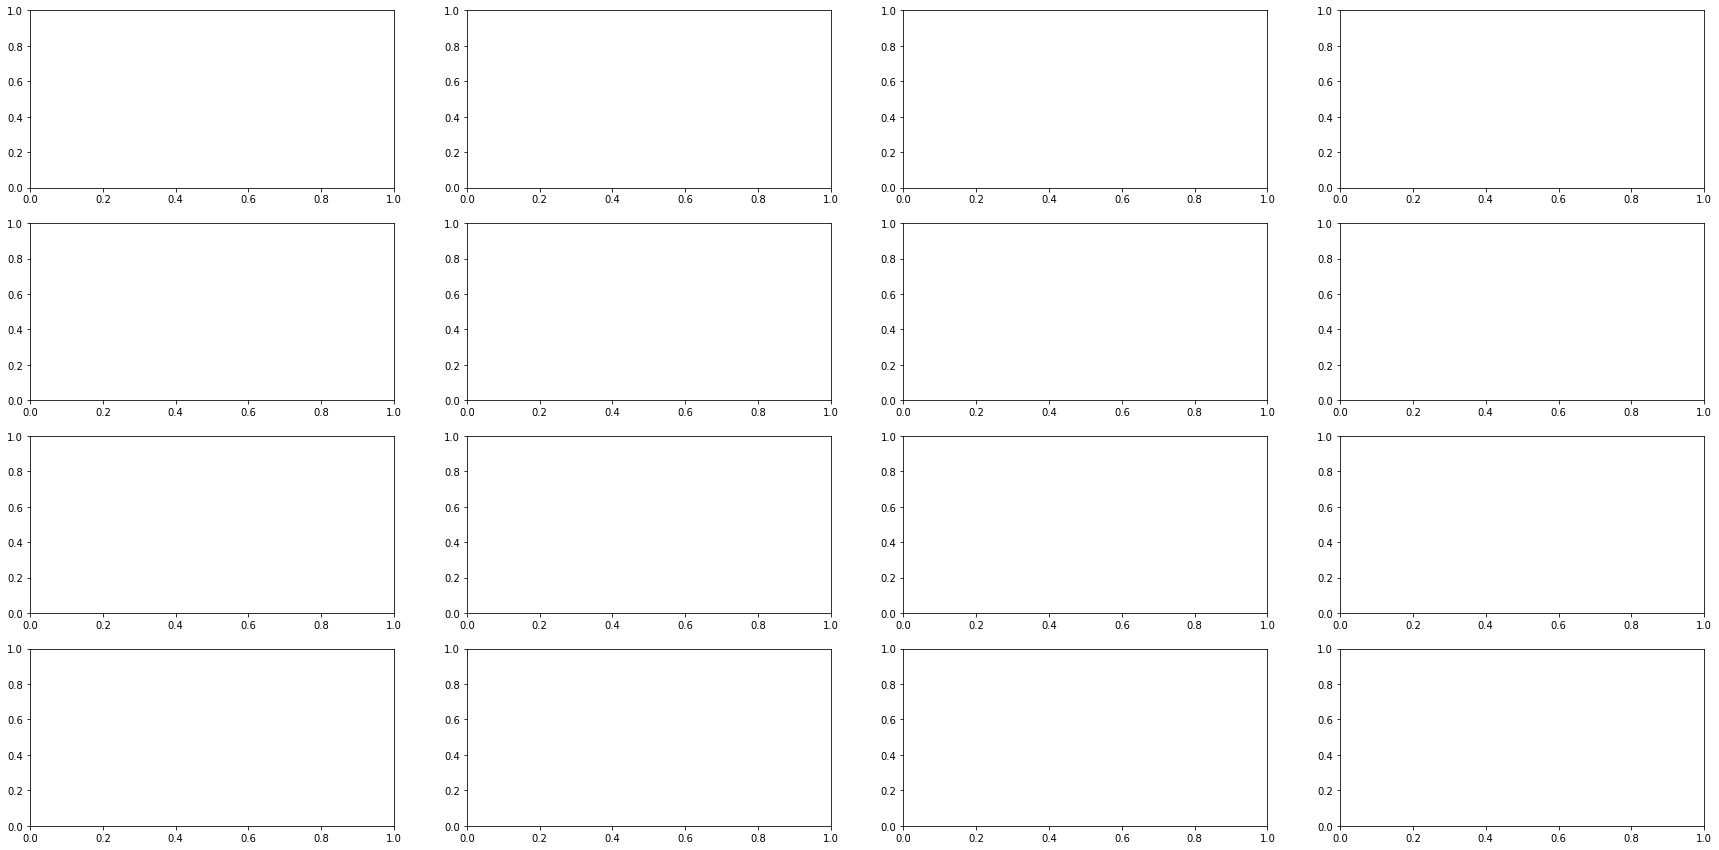

In [148]:
srate = 256

start = 10
stop = 40

sig = da[0,start*srate:stop*srate].values
time = gh.time_vector(sig, srate)

step = 0.5

fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (30,15))

for row, normalisation in enumerate([0 , 10 , 20, 40]):
    for col, f0 in enumerate([1 , 5 , 10 , 20]):
        
        ax = axs[row, col]
        amp = 1
        time_cmw = np.arange(-2,2,1/srate)
        range_freqs = np.linspace(10,40,0.5)
        n_cycles = np.linspace(10,20,step) 
        m = 0

        cmw_family_params = {'amp':amp, 'time':time_cmw, 'n_cycles':n_cycles, 'm':m, 'range':range_freqs}
        tf_moi = homemade_tf(sig , time_sig = time , cmw_family_params = cmw_family_params , module_method = 'abs')

        ax.pcolormesh(time, np.arange(10,20,step), tf_moi.values)
        ax.set_title(f'norm : {normalisation} - f0 : {f0}')

plt.savefig('../../cmo_wavelet')
plt.show()

In [10]:
def cmo_tf(sig, f_start, f_stop, delta_freq, srate, f0=5, normalisation=0):
    wf = generate_wavelet_fourier(len_wavelet=sig.size, f_start=10, f_stop=20, delta_freq=step, sampling_rate=srate, f0=f0, normalisation=normalisation)
    wt = convolve_scalogram(sig, wf)
    tf_matrix = np.abs(wt).T # axis 0 = freqs, axis 1 = time
    return tf_matrix 

In [11]:
tf_matrix = cmo_tf(sig, f_start=10 , f_stop=20, delta_freq=0.5, srate=srate)

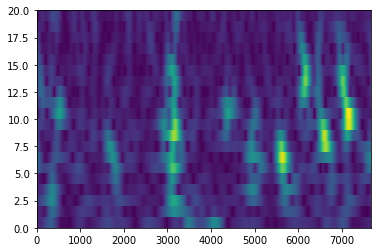

In [12]:
plt.pcolormesh(tf_matrix)
plt.show()

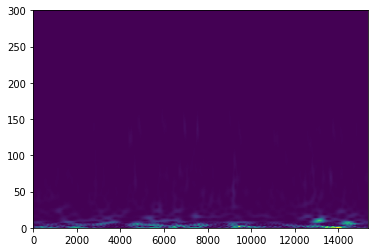

In [77]:
tf_matrix = gh.extract_features_from_cmw_family(sig=sig, time_sig=time, cmw_family_params=cmw_family_params)
plt.pcolormesh(tf_matrix)
plt.show()

In [48]:
start = 120
stop = 180

f_start = 10
f_stop = 20
delta_freq = 0.05

srate = 256

sig = da[0,start*srate:stop*srate].values
time = gh.time_vector(sig, srate)
tf_matrix = gh.cmo_tf(sig=sig, len_wavelet=sig.size, f_start=f_start , f_stop=f_stop, delta_freq=delta_freq, srate=srate, f0 = 10, return_as_da=True)
freqs = np.arange(f_start, f_stop, delta_freq)

In [211]:
f1 = 14
f2 = 25
m = 30
n = 5
srate = 1000
time = np.arange(0 , 60 , 1/srate)
s = n / (2 * np.pi * 10)
GaussWin = np.exp( -(time - m)** 2 / (2 * s**2))
sig_simulate = (np.sin(2 * np.pi * f1 * time) + np.sin(2 * np.pi * f2 * time)) * GaussWin

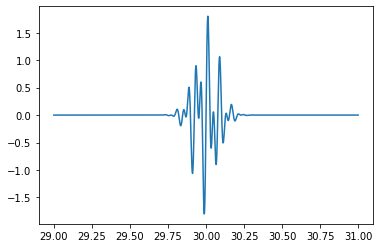

In [212]:
fig, ax = plt.subplots()
ax.plot(time[29*srate:31*srate], sig_simulate[29*srate:31*srate])

In [213]:
tf = gh.cmo_tf(sig_simulate , sig_simulate.size, 1, 30 , 0.1 ,srate = 256, normalisation = 0)

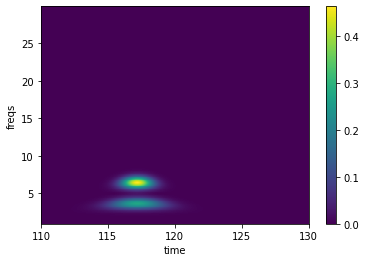

In [214]:
tf.sel(time = slice(110,130)).plot()

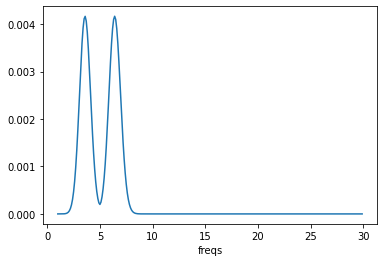

In [215]:
tf.mean('time').plot()

In [265]:
step = 300 # n_wavelets
start_freq = 10 # start wavelet freq
stop_freq = 30 # stop wavelet freq

tf_moi = homemade_tf(sig=sig_simulate , f_start = start_freq, f_stop=stop_freq , cycle_start=10, cycle_stop=30, n_steps = step, srate=srate, wavelet_duration=30, squaring=True)

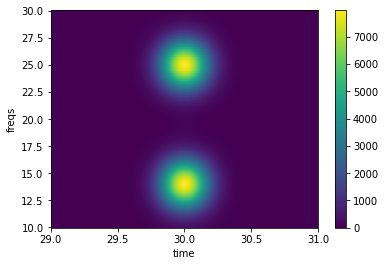

In [266]:
tf_moi.sel(time = slice(29,31)).plot()

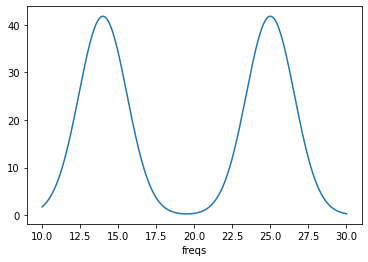

In [267]:
tf_moi.mean('time').plot()